# CH3 시맨틱 분할(PSPNet) 



In [2]:
import os.path as osp
import random
# 파일이나 텍스트에서 XML을 읽고, 가공하고 저장하기 위한 라이브러리
import xml.etree.ElementTree as ET

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data as data
from PIL import Image
import torch.nn as nn

%matplotlib inline

## CH3.2 데이터셋과 데이터 로더 구현

### CH3.2.2 화상 데이터 및 어노테이션 데이터 파일의 경로 리스트 작성

In [3]:
def make_datapath_list(root_path):
  """
  데이터 경로를 저장한 리스트를 작성한다.

  Parameters
  ------------
  root_path : str - 폴더 경로

  Returns
  ------------
  ret : train_img_list, train_anno_list, val_img_list, val_anno_list - 데이터 경로를 저장한 리스트

  """

  # 화상파일과 어노테이션 파일의 경로 템플릿 작성
  imgpath_template = osp.join(root_path, "JPEGImages","%s.jpg")
  annopath_template = osp.join(root_path, "SegmentationClass","%s.png")
  
  # 훈련 및 검증 파일 ID 취득
  train_id_names = osp.join(root_path + "ImageSets/Segmentation/train.txt")
  val_id_names = osp.join(root_path + "ImageSets/Segmentation/val.txt")

  # 경로 리스트 정의
  train_img_list = list()
  train_anno_list = list()

  for line in open(train_id_names):
    file_id = line.strip()
    img_path = (imgpath_template % file_id)
    anno_path = (annopath_template % file_id)
    train_img_list.append(img_path)
    train_anno_list.append(anno_path)  
  
  
  val_img_list = list()
  val_anno_list = list()

  for line in open(val_id_names):
    file_id = line.strip()
    img_path = (imgpath_template % file_id)
    anno_path = (annopath_template % file_id)
    val_img_list.append(img_path)
    val_anno_list.append(anno_path)

  return train_img_list, val_img_list, train_anno_list, val_anno_list
  

In [4]:
root_path = '/content/drive/MyDrive/만들면서_배우는_파이토치_딥러닝/2_objectdetection/data/VOCdevkit/VOC2012/'

train_img_list, val_img_list, train_anno_list, val_anno_list = make_datapath_list(root_path=root_path)

print(train_img_list[0])
print(train_anno_list[0])
print(val_img_list[0])
print(val_anno_list[0])

/content/drive/MyDrive/만들면서_배우는_파이토치_딥러닝/2_objectdetection/data/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg
/content/drive/MyDrive/만들면서_배우는_파이토치_딥러닝/2_objectdetection/data/VOCdevkit/VOC2012/SegmentationClass/2007_000032.png
/content/drive/MyDrive/만들면서_배우는_파이토치_딥러닝/2_objectdetection/data/VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg
/content/drive/MyDrive/만들면서_배우는_파이토치_딥러닝/2_objectdetection/data/VOCdevkit/VOC2012/SegmentationClass/2007_000033.png


### CH3.2.3 데이터셋 작성

In [5]:
cd /content/drive/MyDrive/만들면서_배우는_파이토치_딥러닝/3_semantic_segmentation

/content/drive/MyDrive/만들면서_배우는_파이토치_딥러닝/3_semantic_segmentation


In [6]:
from utils.data_augumentation import Compose, Scale, RandomRotation, RandomMirror, Resize, Normalize_Tensor

class DataTransformation():
  """
  어노테이션 및 데이터 전처리 및 증강 클래스.

  Attributes
  -------------
  input_size : int - 입력 화상 크기
  color_mean : (R,G,B) - 각 색상 채널의 평균값
  color_std : (R,G,B) - 각 색상 채널의 표준편차
  """

  def __init__(self, input_size, color_mean, color_std):
    self.data_transform = {
        'train' : Compose([
                           Scale(scale = [0.5,1.5]),
                           RandomRotation(angle=[-10,10]),
                           RandomMirror(),
                           Resize(input_size),
                           Normalize_Tensor(color_mean, color_std)
        ]),
        'valid' : Compose([
                           Resize(input_size),
                           Normalize_Tensor(color_mean, color_std)
        ])
    }

  def __call__(self, phase, img, anno_class_img):
    return self.data_transform[phase](img, anno_class_img)

In [7]:
class VOCDataset(data.Dataset):
  """
  Dataset 작성 클래스. 파이토치의 dataset 클래스를 상속받는다

  Attributes
  ----------
  img_list : 리스트 - 이미지 파일의 경로를 저장한 리스트
  anno_list : 리스트 - 어노테이션 파일의 경로를 저장한 리스트
  phase : 'train' or 'test'
  transform : 전처리 클래스 인스턴스
  """

  def __init__(self, img_list, anno_list, phase, transform):
    self.img_list= img_list
    self.anno_list = anno_list
    self.phase = phase
    self.transform = transform

  def __len__(self):
    """
    이미지의 매수 반환 
    """
    return len(self.img_list)
  
  def __getitem__(self, index):
    """
    전처리한 이미지의 텐서 형식 데이터와 어노테이션 취득 
    """
    img, anno_class_img = self.pull_item(index)
    return img, anno_class_img
  
  def pull_item(self, index):
    """
    화상의 텐서 형식 데이터와 어노테이션 취득 
    """

    image_file_path = self.img_list[index]
    img = Image.open(image_file_path)

    anno_file_path = self.anno_list[index]
    anno_class_img = Image.open(anno_file_path)

    img, anno_class_img = self.transform(self.phase, img, anno_class_img)
    # def __call__(self, phase, img, anno_class_img): # 페이즈가 설정되고, 화상과 어노테이션이 그 뒷자리를 잇는다.
    # 반환되는 것은 증강/전처리 된 이미지와 annotation의 세트
    return img, anno_class_img

In [8]:
color_mean = (0.485, 0.456, 0.406)
color_std  = (0.229, 0.224, 0.225)

In [9]:
transform = DataTransformation(input_size = 475, color_mean = color_mean, color_std = color_std)

In [10]:
train_dataset = VOCDataset(train_img_list, train_anno_list, phase = 'train', transform = transform)
val_dataset = VOCDataset(val_img_list, val_anno_list, phase ='valid', transform = transform)

In [11]:
# print(val_dataset.__getitem__(0)[0].shape) # 이미지
#rint(val_dataset.__getitem__(0)[1].shape) # 어노테이션

### CH3.2.4 데이터 로더 작성하기

In [12]:
batch_size = 8
train_dataloader = data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_dataloader = data.DataLoader(val_dataset, batch_size = batch_size, shuffle = True)
dataloaders_dict = {"train":train_dataloader , "valid":val_dataloader}

batch_iterator = iter(dataloaders_dict["valid"])
image, anno_class_imges = next(batch_iterator)
print(image.size()) #배치 크기, 채널 수, 너비, 높이
print(anno_class_imges.size()) # 배치 크기, 너비, 높이

torch.Size([8, 3, 475, 475])
torch.Size([8, 475, 475])


## CH3.3 PSPNet 네트워크 구성 및 구현

In [13]:
# 목표
# PSPNet 네트워크 구조를 모듈 단위로 이해
# PSPNet을 구성하는 각 모듈의 역할을 이해
# PSPNet 네트워크 클래스의 구현을 이해

class PSPNet(nn.Module):
  def __init__(self, n_classes):
    super(PSPNet, self).__init__()

    block_config = [3,4,6,3] #RESNET 50
    img_size = 475
    img_size_8 = 60

    # 모델 내부 시스템 구성
    self.feature_conv = FeatureMap_convolution()
    # Feature conv는 128 119 119 잘 넘김
    self.feature_res_1 = ResidualBlockPSP(
        n_blocks = block_config[0], in_channels = 128, mid_channels = 64, out_channels = 256,
        stride = 1, dilation = 1
    )
    # 256 119 119
    self.feature_res_2 = ResidualBlockPSP(
        n_blocks = block_config[1], in_channels = 256, mid_channels = 128, out_channels = 512,
        stride = 2, dilation = 1
    )
    # 512 119 119
    self.feature_dilated_res_1 = ResidualBlockPSP(
        n_blocks = block_config[2], in_channels = 512, mid_channels = 256, out_channels = 1024,
        stride = 1, dilation = 2
    )
    self.feature_dilated_res_2 = ResidualBlockPSP(
        n_blocks = block_config[3], in_channels = 1024, mid_channels = 512, out_channels = 2048,
        stride = 1, dilation = 4
    )
    self.pyramid_pooling = PyramidPooling(in_channels = 2048, pool_sizes = [6,3,2,1],
                                          height=img_size_8, width =img_size_8)
    self.decode_feature = DecodePSPFeature(
        height=img_size, width = img_size, n_classes = n_classes
    )
    self.aux = AuxiliaryPSPlayers(
        in_channels = 1024, height = img_size, width = img_size, n_classes = n_classes
    )
  def forward(self, x):
    # Encoder
    x = self.feature_conv(x)
    x = self.feature_res_1(x)
    x = self.feature_res_2(x)
    x = self.feature_dilated_res_1(x)

    # Auxiliary output
    output_aux = self.aux(x)

    x = self.feature_dilated_res_2(x)


    # Pyramid Pooling
    x = self.pyramid_pooling(x)

    #decoder
    output = self.decode_feature(x)
    return (output, output_aux)

## CH3.4 Feature(인코더) 모듈 설명 및 구현 (RESNet)



1.   Feature 모듈의 서브 네트워크 구성 이해
2.   서브 네트워크 FeatureMap_convolution을 이해
3.   Residual Block 이해
4.   Dilated Convolution 이해
5.   서브 네트워크 bottleNeckPSP와 bottleNeckIdentifyPSP구현
6.   Feature 모듈의 구현



### CH3.4.2 서브 네트워크 FeatureMap_convolution

In [14]:
class conv2DBatchNormRelu(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding, dilation, bias):
    super(conv2DBatchNormRelu,self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size,
                          stride, padding, dilation, bias=bias)
    self.batchnorm = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU(inplace = True) # 메모리 절약

  def forward(self,x):
    x = self.conv(x)
    x = self.batchnorm(x)
    outputs = self.relu(x)
    return outputs

In [15]:
class FeatureMap_convolution(nn.Module):
  def __init__(self):
    """
    구성할 네트워크 준비
    """

    super(FeatureMap_convolution, self).__init__()

    #1층
    in_channel, out_channel = 3,64
    kernel_size = 3
    stride = 2
    padding = 1
    dilation = 1
    bias = False
    self.cbnr_1 = conv2DBatchNormRelu(in_channel, out_channel, kernel_size,
                                      stride, padding, dilation, bias)
    
    #2층
    in_channel, out_channel = 64,64
    kernel_size = 3
    stride = 1
    padding = 1
    dilation = 1
    bias = False
    self.cbnr_2 = conv2DBatchNormRelu(in_channel, out_channel, kernel_size,
                                      stride, padding, dilation, bias)
    
    #3층
    in_channel, out_channel = 64,128
    kernel_size = 3
    stride = 1
    padding = 1
    dilation = 1
    bias = False
    self.cbnr_3 = conv2DBatchNormRelu(in_channel, out_channel, kernel_size,
                                      stride, padding, dilation, bias)
    
    self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
    
  def forward(self,x):
    x = self.cbnr_1(x)
    x = self.cbnr_2(x)
    x = self.cbnr_3(x)
    outputs = self.maxpool(x)
    return outputs

### CH3.4.4 ResidualBlockPSP

In [16]:
class ResidualBlockPSP(nn.Sequential):
  def __init__(self, n_blocks, in_channels, mid_channels, out_channels, stride, dilation):
    super(ResidualBlockPSP, self).__init__()

    self.add_module(
        "block1",bottleNeckPSP(in_channels, mid_channels, out_channels, stride, dilation)
    )

    for i in range(n_blocks - 1): # 앞에서 하나 해버려서 1 뺀다.
      self.add_module(
          "block"+str(i+2), 
          bottleNeckIdentifyPSP(out_channels,mid_channels ,stride = stride, dilation=dilation)
      )

### CH3.4.5 bottleNeckPSP와 bottleNeckIdentifyPSP 

In [17]:
class conv2DBatchNorm(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding, dilation, bias):
    super(conv2DBatchNorm,self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride,padding,dilation, bias = bias)
    self.batchnorm = nn.BatchNorm2d(out_channels)
  def forward(self,x):
    x = self.conv(x)
    x = self.batchnorm(x)
    return x

class bottleNeckPSP(nn.Module):
  def __init__(self, in_channels, mid_channels, out_channels, stride, dilation):
    super(bottleNeckPSP, self).__init__()

    self.cbr_1 = conv2DBatchNorm(in_channels, mid_channels, kernel_size=1, stride = 1, padding = 0
                                 ,dilation = 1, bias = False)
    self.cbr_2 = conv2DBatchNorm(mid_channels, mid_channels, kernel_size=3, stride = stride, padding = dilation
                                 ,dilation = dilation, bias = False)
    self.cbr_3 = conv2DBatchNorm(mid_channels, out_channels, kernel_size=1, stride = 1, padding = 0
                                 ,dilation = 1, bias = False)
    
    self.cb_residual = conv2DBatchNorm(in_channels, out_channels, kernel_size = 1,dilation = 1,
                                       stride = stride, padding = 0, bias = False)
    self.relu = nn.ReLU(inplace = True)

  def forward(self, x):
    conv = self.cbr_3(self.cbr_2(self.cbr_1(x)))
    residual = self.cb_residual(x)
    return self.relu(conv + residual)


class bottleNeckIdentifyPSP(nn.Module):
  def __init__(self, in_channels, mid_channels,  stride, dilation):
    super(bottleNeckIdentifyPSP, self).__init__()

    self.cbr_1 = conv2DBatchNorm(in_channels, mid_channels, kernel_size=1, stride = 1, padding = 0
                                 ,dilation = 1, bias = False)
    self.cbr_2 = conv2DBatchNorm(mid_channels, mid_channels, kernel_size=3, stride = 1, padding = dilation
                                 ,dilation = dilation, bias = False)
    self.cbr_3 = conv2DBatchNorm(mid_channels, in_channels, kernel_size=1, stride = 1, padding = 0
                                 ,dilation = 1, bias = False)
    self.relu = nn.ReLU(inplace = True)

  def forward(self, x):
    conv = self.cbr_3(self.cbr_2(self.cbr_1(x)))
    residual = x
    return self.relu(conv + residual)

## CH3.5 Pyramid Pooling 모듈 설명 및 구현

In [18]:
import torch.nn.functional as F

class PyramidPooling(nn.Module):
  def __init__(self, in_channels, pool_sizes, height, width):
    super(PyramidPooling, self).__init__()
    self.height = height
    self.width = width
    
    # 각 합성곱 층의 출력 채널
    out_channels = int(in_channels/len(pool_sizes))

    self.avpool_1 = nn.AdaptiveAvgPool2d(output_size = pool_sizes[0])
    self.cbr_1 = conv2DBatchNorm(in_channels, out_channels, kernel_size = 1, stride = 1, padding = 0,
                                 dilation = 1, bias = False)
    self.avpool_2 = nn.AdaptiveAvgPool2d(output_size = pool_sizes[1])
    self.cbr_2 = conv2DBatchNorm(in_channels, out_channels, kernel_size = 1, stride = 1, padding = 0,
                                 dilation = 1, bias = False)
    self.avpool_3 = nn.AdaptiveAvgPool2d(output_size = pool_sizes[2])
    self.cbr_3 = conv2DBatchNorm(in_channels, out_channels, kernel_size = 1, stride = 1, padding = 0,
                                 dilation = 1, bias = False)
    self.avpool_4 = nn.AdaptiveAvgPool2d(output_size = pool_sizes[3])
    self.cbr_4 = conv2DBatchNorm(in_channels, out_channels, kernel_size = 1, stride = 1, padding = 0,
                                 dilation = 1, bias = False)
    
  def forward(self,x):
    # bilinear interpolate 로 업샘플링을 진행해서 굉장히 낮은 코스트로 업샘플링을 수행하네
    out1 = self.cbr_1(self.avpool_1(x))
    out1 = F.interpolate(out1, size = (self.height, self.width),mode = 'bilinear',align_corners = True)
    
    out2 = self.cbr_2(self.avpool_2(x))
    out2 = F.interpolate(out2, size = (self.height, self.width),mode = 'bilinear',align_corners = True)
    
    out3 = self.cbr_3(self.avpool_3(x))
    out3 = F.interpolate(out3, size = (self.height, self.width),mode = 'bilinear',align_corners = True)
    
    out4 = self.cbr_4(self.avpool_4(x))
    out4 = F.interpolate(out4, size = (self.height, self.width),mode = 'bilinear',align_corners = True)
    
    output = torch.cat([x,out1,out2,out3,out4], dim = 1)
    return output


## CH3.6 Decode, AuxLoss 모듈 설명 및 구현

### CH3.6.1 Decoder 및 AuxLoss 모듈 구조

In [19]:
class DecodePSPFeature(nn.Module) :
  def __init__(self, height, width, n_classes):
    super(DecodePSPFeature, self).__init__()
    self.height = height
    self.width = width
    self.cbr = conv2DBatchNormRelu(in_channels = 4096, out_channels = 512,
                               kernel_size = 3, stride = 1, padding = 1, dilation = 1, bias = False)
    self.dropout = nn.Dropout2d(p=0.1)
    self.classification = nn.Conv2d(in_channels = 512, out_channels = n_classes, kernel_size = 1,
                                     stride = 1, padding = 0)
    
  def forward(self, x):
    x = self.classification(self.dropout(self.cbr(x)))
    x = F.interpolate(x,size=(self.height, self.width), mode = 'bilinear', align_corners=True)
    return x


class AuxiliaryPSPlayers(nn.Module):
  def __init__(self, in_channels, height, width, n_classes):
    super(AuxiliaryPSPlayers,self).__init__()
    self.height = height
    self.width = width
    self.cbr = conv2DBatchNormRelu(in_channels = in_channels, out_channels = 256,
                               kernel_size = 3, stride = 1, padding = 1, dilation = 1, bias = False)
    self.classification = nn.Conv2d(in_channels = 256, out_channels = n_classes, kernel_size = 1,
                                     stride = 1, padding = 0)
    self.dropout = nn.Dropout2d(p=0.1)
    
  def forward(self, x):
    x = self.classification(self.dropout(self.cbr(x)))
    x = F.interpolate(x,size=(self.height, self.width), mode = 'bilinear', align_corners=True)
    return x

In [20]:
net = PSPNet(n_classes = 21)
net

PSPNet(
  (feature_conv): FeatureMap_convolution(
    (cbnr_1): conv2DBatchNormRelu(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (cbnr_2): conv2DBatchNormRelu(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (cbnr_3): conv2DBatchNormRelu(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (feature_res_1): ResidualBlockPSP(
    (block1): bottleNec

In [21]:
batch_size = 2
dummy_img = torch.rand(batch_size, 3, 475,475)
outputs = net(dummy_img)

## CH3.7 파인튜닝을 활용한 학습 및 검증 실시

### CH3.7.2 학습 및 검증 구현

In [21]:
# "weights" 폴더에 네트워크의 초기치로써 사용할 "pspnet50_ADE20K.pth"를
# 필자의 Google Drive에서 다운로드
# file_id="12eN6SpnawYuQmD1k9VgVW3QSgPR6hICc"
# file_name="pspnet50_ADE20K.pth"

!curl -sc /tmp/cookie "https://drive.google.com/uc?export=download&id=12eN6SpnawYuQmD1k9VgVW3QSgPR6hICc" > /dev/null
!curl -Lb /tmp/cookie "https://drive.google.com/uc?export=download&confirm=$(awk '/_warning_/ {print $NF}' /tmp/cookie)&id=12eN6SpnawYuQmD1k9VgVW3QSgPR6hICc" -o "pspnet50_ADE20K.pth"

# 파일 이동
!mv pspnet50_ADE20K.pth ./weights

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   4000      0 --:--:-- --:--:-- --:--:--  4000
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  187M  100  187M    0     0  65.5M      0  0:00:02  0:00:02 --:--:-- 76.9M


In [49]:
from utils.pspnet import PSPNet
net = PSPNet(n_classes = 150) # 파이토치에서는 사전학습된 모델을 불러올 때, 구조는 이미 완성 되어 있어야 한다.
state_dict = torch.load("./weights/pspnet50_ADE20K.pth") # 모델 로드는 딕셔너리 형태로 이루어지나 보다.
net.load_state_dict(state_dict) # 구조에 가중치를 덮어 씌운다.

print(net.decode_feature) #교체해야 하는 층을 확인한다.
n_classes = 21
net.decode_feature.classification = nn.Conv2d(in_channels = 512, out_channels = n_classes,
                                              kernel_size = 1, stride = 1, padding = 0) # 마지막 층 재정의

print(net.aux) # 교체해야 하는 층을 확인한다.
net.aux.classification = nn.Conv2d(in_channels = 256, out_channels = n_classes,
                                              kernel_size = 1, stride = 1, padding = 0) # 마지막 층 재정의

print("마지막 출력층의 클래스 갯수 변경 완료")

def weights_init(m):
  if isinstance(m,nn.Conv2d):
    nn.init.xavier_normal_(m.weight.data)
    if m.bias is not None:
      nn.init.constant_(m.bias, 0.0)

net.decode_feature.classification.apply(weights_init)
net.aux.classification.apply(weights_init)
print("네트워크 설정 완료: 사전학습된 가중치 로드 완료")

DecodePSPFeature(
  (cbr): conv2DBatchNormRelu(
    (conv): Conv2d(4096, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batchnorm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (dropout): Dropout2d(p=0.1, inplace=False)
  (classification): Conv2d(512, 150, kernel_size=(1, 1), stride=(1, 1))
)
AuxiliaryPSPlayers(
  (cbr): conv2DBatchNormRelu(
    (conv): Conv2d(1024, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (dropout): Dropout2d(p=0.1, inplace=False)
  (classification): Conv2d(256, 150, kernel_size=(1, 1), stride=(1, 1))
)
마지막 출력층의 클래스 갯수 변경 완료
네트워크 설정 완료: 사전학습된 가중치 로드 완료


In [50]:
class PSPLoss(nn.Module):
  """PSPNet손실함수 네트워크"""

  def __init__(self, aux_weight = 0.4):
    super(PSPLoss, self).__init__()
    self.aux_weight = aux_weight

  def forward(self,outputs, targets):
    """손실함수 계산
    Parameters
    ------------
    outputs: PSPNet의 출력 (21,475,475) 크기이며, 각 셀은 해당 클래스일 시그모이드 확률을 나타냄.
    targets : [num_batch, 475, 475] - 어노테이션 입력

    Returns 
    -------------
    loss : 텐서. 평균값으로 계산되어 반환된다.
    """
    loss = F.cross_entropy(outputs[0], targets, reduction = 'mean')
    loss_aux = F.cross_entropy(outputs[1], targets, reduction = 'mean')
    return loss + self.aux_weight*loss_aux

criterion = PSPLoss()

### CH3.7.3 스케줄러로 에폭별 학습 비율 조정

In [51]:
import torch.optim as optim
import math
optimizer = optim.Adam([
                        {'params':net.feature_conv.parameters(), 'lr':1e-3 },
                        {'params':net.feature_res_1.parameters(), 'lr':1e-3 },
                        {'params':net.feature_res_2.parameters(), 'lr':1e-3 },
                        {'params':net.feature_dilated_res_1.parameters(), 'lr':1e-3 },
                        {'params':net.feature_dilated_res_2.parameters(), 'lr':1e-3 },
                        {'params':net.pyramid_pooling.parameters(), 'lr':1e-3 },
                        {'params':net.decode_feature.parameters(), 'lr':1e-2 }, # 출력단에 가까울 수록 커지는 학습률
                        {'params':net.aux.parameters(), 'lr':1e-2 },
], weight_decay = 0.0001)

def lambda_epoch(epoch): # 학습률 스케줄러. 학습이 진행될수록 학습률이 점진적으로 작아진다.
  max_epoch = 30
  return math.pow((1-epoch/max_epoch), 0.9)

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda_epoch)

In [54]:
import time
import pandas as pd
def train_model(net, dataloaders_dict, criterion, scheduler, optimizer, num_epochs):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print("현재 장치 :",device)
  net.to(device) # 장치에 모델을 얹는다

  torch.backends.cudnn.benchmark = True # 하드웨어 가속
  # dataloaders_dict는 앞에서 학습, 검증 데이터로더를 하나로 묶어둔 딕셔너리임.
  num_train_imgs = len(dataloaders_dict["train"].dataset)
  num_val_imgs = len(dataloaders_dict["valid"].dataset)
  batch_size = dataloaders_dict["train"].batch_size

  # 이터레이터의 반복횟수 카운트
  iteration = 1
  logs = []

  batch_multiplier = 3 # 이번 구현의 특이점. 멀티플 미니 배치 -> 배치 정규화의 안전성을 높이기 위해서 채용
  for epoch in range(num_epochs):
    t_epoch_start = time.time()
    t_iter_start = time.time()
    epoch_train_loss = 0.
    epoch_val_loss = 0.
    print("---------------")
    print("Epoch {}/{}".format(epoch+1, num_epochs))
    print("---------------")

    #에폭 안에서 검증도 해보자.
    for phase in ['train','valid']:
      if phase == 'train':
        net.train()
        scheduler.step() # 우리는 스케줄러가 매 스텝 변하기 때문에 최신화가 필요하다.
        optimizer.zero_grad() # 옵티마이저를 0으로 싹다 초기화해준다.
        print("   (train)  ")
      else :
        if ((epoch+1)%5==0):
          net.eval() # 검증때는 학습 안되도록 한다.
          print("---------------")
          print("   (val)  ")
        else : 
          continue # 검증은 5번 중 한번만 시행
      
      # 데이터 로더에서 미니 배치씩 꺼내서 루프 돌리자.
      count = 0 # 멀티플 미니 배치
      
      for imges, anno_class_imges in dataloaders_dict[phase]:
        if imges.size()[0] == 1:
          continue # 미니배치의 크기가 1인 경우에 배치정규화가 작동하지 않기 대문에 예외사항 투입
        
        imges = imges.to(device) # GPU에 미니배치 데이터를 탑재
        anno_class_imges = anno_class_imges.to(device)

        if(phase == 'train') and (count ==0):
          optimizer.step()
          optimizer.zero_grad() # 분할 배치 정규화가 이루어질 때만 그래디언트 초기화가 이루어진다.
          count = batch_multiplier

        with torch.set_grad_enabled(phase =='train'):
          outputs = net(imges)
          loss = criterion(outputs, anno_class_imges.long())/batch_multiplier # int 64 (long) type으로 어노테이션 변경
          if phase == 'train' : # 훈련 스텝에서 역전파
            loss.backward()
            count -=1 # 멀티플 미니 배치

            if (iteration%10 == 0):
              t_iter_finish = time.time()
              duration = t_iter_finish - t_iter_start
              print("반복 {} || LOSS : {:.4f} || 10iter : {:.4f} sec.".format(iteration, loss.item()/batch_size*batch_multiplier, duration))
              t_iter_start = time.time()
            epoch_train_loss += loss.item()*batch_multiplier
            iteration = iteration + 1
          if phase == 'valid': 
            epoch_val_loss += loss.item()*batch_multiplier

    t_epoch_finish = time.time()
    print("----------------")
    print("epoch {} || Epoch_TRAIN_Loss : {:.4f} || Epoch_VAL_Loss: {:.4f}".format(
        epoch+1, epoch_train_loss/num_train_imgs, epoch_val_loss/num_val_imgs))
    print("timer : {:.4f} sec.".format(t_epoch_finish - t_epoch_start))
    t_epoch_start = time.time()

    log_epoch = {"epoch":epoch +1, "train_loss":epoch_train_loss/num_train_imgs, 'val_loss':epoch_val_loss/num_val_imgs}
    logs.append(log_epoch)
    df = pd.DataFrame(logs)
    df.to_csv("log_output")

  torch.save(net.state_dict(), './weights/pspnet50_'+str(epoch+1)+'.pth')

In [55]:
num_epochs = 5
train_model(net, dataloaders_dict, criterion, scheduler, optimizer, num_epochs = num_epochs)

현재 장치 : cuda:0
---------------
Epoch 1/5
---------------
   (train)  
반복 10 || LOSS : 0.2420 || 10iter : 13.3432 sec.
반복 20 || LOSS : 0.2763 || 10iter : 13.2621 sec.
반복 30 || LOSS : 0.1961 || 10iter : 13.2818 sec.
반복 40 || LOSS : 0.1523 || 10iter : 13.2810 sec.
반복 50 || LOSS : 0.2090 || 10iter : 13.2986 sec.
반복 60 || LOSS : 0.1554 || 10iter : 13.2934 sec.
반복 70 || LOSS : 0.2895 || 10iter : 13.2851 sec.
반복 80 || LOSS : 0.1673 || 10iter : 13.3231 sec.
반복 90 || LOSS : 0.3209 || 10iter : 13.2336 sec.
반복 100 || LOSS : 0.1189 || 10iter : 13.3260 sec.
반복 110 || LOSS : 0.2306 || 10iter : 13.3427 sec.
반복 120 || LOSS : 0.1119 || 10iter : 13.2275 sec.
반복 130 || LOSS : 0.1546 || 10iter : 13.3624 sec.
반복 140 || LOSS : 0.1422 || 10iter : 13.2002 sec.
반복 150 || LOSS : 0.1919 || 10iter : 13.2414 sec.
반복 160 || LOSS : 0.1308 || 10iter : 13.3168 sec.
반복 170 || LOSS : 0.0831 || 10iter : 13.2809 sec.
반복 180 || LOSS : 0.2151 || 10iter : 13.3660 sec.
----------------
epoch 1 || Epoch_TRAIN_Loss : 0.1763 || 

## CH3.8 시맨틱 분할 추론

In [22]:
from utils.dataloader import make_datapath_list, DataTransform

# 파일 경로 리스트 작성
rootpath = "./data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath=rootpath)

# 나중에 어노테이션 화상만 사용한다

In [23]:
from utils.pspnet import PSPNet

net = PSPNet(n_classes=21)

# 학습된 파라미터를 로드
state_dict = torch.load("./weights/pspnet50_5.pth",
                        map_location={'cuda:0': 'cpu'})
net.load_state_dict(state_dict)

print('네트워크 설정 완료: 학습된 가중치를 로드했습니다')

네트워크 설정 완료: 학습된 가중치를 로드했습니다


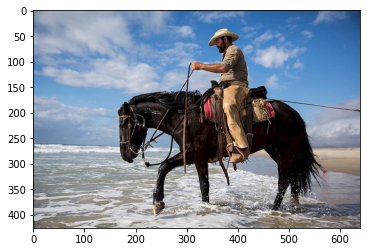

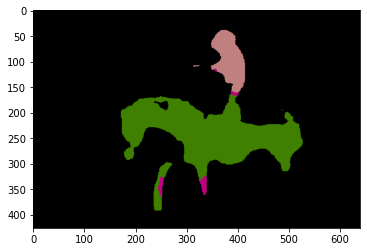

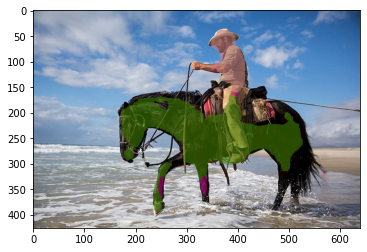

In [24]:
# 1. 원본 화상 표시
image_file_path = "./data/cowboy-757575_640.jpg"
img = Image.open(image_file_path)   # [높이][폭][색RGB]
img_width, img_height = img.size
plt.imshow(img)
plt.show()

# 2. 전처리 클래스 작성
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)
transform = DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std)

# 3. 전처리
# 적당한 어노테이션 화상을 준비하여, 색상 팔레트 정보를 추출
anno_file_path = val_anno_list[0]
anno_class_img = Image.open(anno_file_path)   # [높이][폭]
p_palette = anno_class_img.getpalette()
phase = "val"
img, anno_class_img = transform(phase, img, anno_class_img)

# 4. PSPNet으로 추론한다
net.eval()
x = img.unsqueeze(0)  # 미니 배치화: torch.Size([1, 3, 475, 475])
outputs = net(x)
y = outputs[0]  # AuxLoss 측은 무시, y의 크기는 torch.Size([1, 21, 475, 475])

# 5. PSPNet의 출력으로 최대 클래스를 구해, 색상 팔레트 형식으로 하여, 화상 크기를 원래대로 되돌린다
y = y[0].detach().numpy()  # y: torch.Size([1, 21, 475, 475])
y = np.argmax(y, axis=0)
anno_class_img = Image.fromarray(np.uint8(y), mode="P")
anno_class_img = anno_class_img.resize((img_width, img_height), Image.NEAREST)
anno_class_img.putpalette(p_palette)
plt.imshow(anno_class_img)
plt.show()

# 6. 화상을 투과시켜 겹친다
trans_img = Image.new('RGBA', anno_class_img.size, (0, 0, 0, 0))
anno_class_img = anno_class_img.convert('RGBA')  # 색상 팔레트 형식을 RGBA로 변환

for x in range(img_width):
    for y in range(img_height):
        # 추론 결과 화상의 픽셀 데이터를 취득
        pixel = anno_class_img.getpixel((x, y))
        r, g, b, a = pixel

        # (0, 0, 0)의 배경이라면 그대로 투과시킨다
        if pixel[0] == 0 and pixel[1] == 0 and pixel[2] == 0:
            continue
        else:
            # 그 외 색상은 준비된 화상에 픽셀을 기록한다
            trans_img.putpixel((x, y), (r, g, b, 150))
            # 투과율을 150으로 지정한다

img = Image.open(image_file_path)   # [높이][폭][색RGB]
result = Image.alpha_composite(img.convert('RGBA'), trans_img)
plt.imshow(result)
plt.show()
